## Twitter Sentiment Analysis

Semtiment analysis is the process of understanding the opinion of an author about a subject.

An opinion, also called polarity can be of three types: Positive, Neutral and Negative.Most brands use sentiment analysis to understand how their customers interact and feel about their brand.Sentiment Analysis is also used in Brand monitoring, Cutomer service, Product Analysis and Market research.

Twitter is a gold mine of data. Twitter is an amazing micro blogging tool and an extraordinary communication medium. In addition, it can also be an amazing open mine for text and social web analyses.

In this project, we will be working on twitter dataset that has 1.6 million tweets and do the sentiment analysis of the tweets.

## Setup

In [2]:
import pandas as pd #fordata manipulation, analysis and cleaning
import numpy as np #computing and data manipulation
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visualization
import re
from collections import Counter
from bs4 import BeautifulSoup # for parsing HTML data
from nltk.tokenize import WordPunctTokenizer, word_tokenize #to extract the tokens from string of words or sentences 
import collections
from sklearn.naive_bayes import MultinomialNB
from PIL import Image
from wordcloud import WordCloud
from sklearn import metrics
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix 
from sklearn.svm import LinearSVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer   
import warnings
warnings.filterwarnings("ignore")

## Importing the Dataset

Now that the setup is done, Let us import the dataset and have a look at it.

In [4]:
data_columns = ["target", "id", "date", "query", "user", "text"]
data_encoding = "ISO-8859-1"
data = pd.read_csv('../training_data.csv', encoding = data_encoding ,names=data_columns)
data.head()

,target,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   query   1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


The dataset has 1.6 million records with 6 columns as follows:

    - sentiment: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)    
    - ids: The id of the tweet    
    - date: the date of the tweet    
    - query: The query. If there is no query, then this value is NO_QUERY.
    - user: the user that tweeted
    - text: the text of the tweet

Now, Let us have a look at how many positive and negative tweets we have in our data.

In [6]:
data.target.value_counts()

4    800000
0    800000
Name: target, dtype: int64

From the above two steps it is clear that the dataset has 1.6 million entries
There are no null entries
The "sentiment" column suggests that the 50% of the training data is with negative label and another 50% with positive label. There are no tweets that are tagged as neautral

Changing the values for convenience sake. So now NEGATIVE represents the negative tweets, POSITIVE represents the positive tweets and NEUTRAL represents neutral tweets

Here, I am making a new dictionary which maps the target variable to the sentiment.

In [7]:
sentiment_dict = [
    {'target' : 0 , 'sentiment' : 'NEGATIVE'},
    {'target' : 4 , 'sentiment' : 'POSITIVE'},
    {'target' : 2 , 'sentiment' : 'NEUTRAL'}
]

In [10]:
sentiment_dictionary = pd.DataFrame(sentiment_dict)

Now that we have two datasets, let us perfoem a left join and merge both of them based on the target, since target is the common column.

In [11]:
dataset = pd.merge(data,sentiment_dictionary , on ='target', how='left')

In [12]:
dataset.head()

,target,id,date,query,user,text,sentiment
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEGATIVE
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,NEGATIVE
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,NEGATIVE
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,NEGATIVE
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",NEGATIVE


Now, going further we will drop the extra columns that we will not need for further analysis and focus only on the relevant columns

In [13]:
dataset.drop(['target','id','date','query','user'],axis=1,inplace=True)

In [14]:
dataset.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEGATIVE
1,is upset that he can't update his Facebook by ...,NEGATIVE
2,@Kenichan I dived many times for the ball. Man...,NEGATIVE
3,my whole body feels itchy and like its on fire,NEGATIVE
4,"@nationwideclass no, it's not behaving at all....",NEGATIVE


### Distribution of tweets based on the sentiment of the tweet

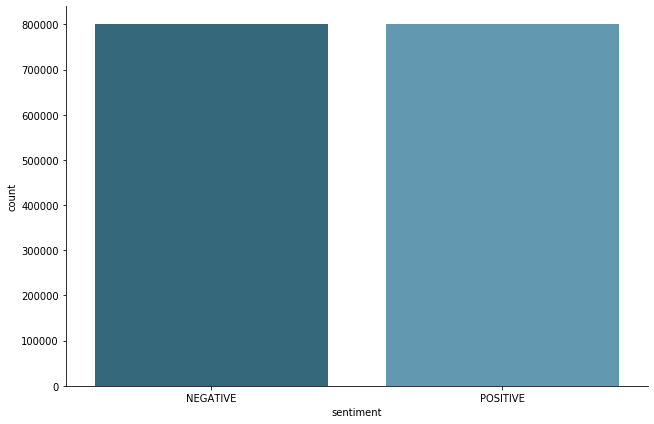

In [15]:
sns.factorplot(x="sentiment", data=dataset, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

Let us have a look at the tweets with negative sentiment.

In [16]:
dataset[dataset.sentiment == "NEGATIVE"].head(10)

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEGATIVE
1,is upset that he can't update his Facebook by ...,NEGATIVE
2,@Kenichan I dived many times for the ball. Man...,NEGATIVE
3,my whole body feels itchy and like its on fire,NEGATIVE
4,"@nationwideclass no, it's not behaving at all....",NEGATIVE
5,@Kwesidei not the whole crew,NEGATIVE
6,Need a hug,NEGATIVE
7,@LOLTrish hey long time no see! Yes.. Rains a...,NEGATIVE
8,@Tatiana_K nope they didn't have it,NEGATIVE
9,@twittera que me muera ?,NEGATIVE


Coming to the tweets with positive sentiment.

In [17]:
dataset[dataset.sentiment == "POSITIVE"].head(10)

,text,sentiment
800000,I LOVE @Health4UandPets u guys r the best!!,POSITIVE
800001,im meeting up with one of my besties tonight! ...,POSITIVE
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",POSITIVE
800003,Being sick can be really cheap when it hurts t...,POSITIVE
800004,@LovesBrooklyn2 he has that effect on everyone,POSITIVE
800005,@ProductOfFear You can tell him that I just bu...,POSITIVE
800006,@r_keith_hill Thans for your response. Ihad al...,POSITIVE
800007,"@KeepinUpWKris I am so jealous, hope you had a...",POSITIVE
800008,"@tommcfly ah, congrats mr fletcher for finally...",POSITIVE
800009,@e4VoIP I RESPONDED Stupid cat is helping me ...,POSITIVE


By looking at the above entries for each type of sentiment, we can observe that all the negative tweets range from ids 0~799999 index, and the positive tweets range from 800000 to the end of the dataset